<a href="https://colab.research.google.com/github/nerbivol/News-Clustering/blob/main/Clustering_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyarabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import glob
from tqdm import tqdm
import time

import re
import nltk
from nltk.stem.isri import ISRIStemmer  
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import KMeans, MeanShift, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Download data

In [ ]:
path_read = '/content/drive/MyDrive/Colab Data/cluster_news/SaudiNewsNet-master/*'
df = [pd.read_json(file) for file in glob.glob(path_read)]


In [ ]:
df_full = pd.concat(df, ignore_index = True)

In [ ]:
df_full

source                                                url  \
0      aawsat  http://aawsat.com/home/article/410826/بريطانيا...   
1      aawsat  http://aawsat.com/home/article/410801/الرئيس-ه...   
2      aawsat  http://aawsat.com/home/article/410796/مجلس-الأ...   
3      aawsat  http://aawsat.com/home/article/410771/«نيران-ص...   
4      aawsat  http://aawsat.com/home/article/410751/الخارجية...   
...       ...                                                ...   
31025     was       http://www.spa.gov.sa/details.php?id=1387081   
31026     was       http://www.spa.gov.sa/details.php?id=1387080   
31027     was       http://www.spa.gov.sa/details.php?id=1387079   
31028     was       http://www.spa.gov.sa/details.php?id=1387078   
31029     was       http://www.spa.gov.sa/details.php?id=1387077   

            date_extracted                                              title  \
0      2015-07-21 02:51:32  بريطانيا: أربعة محاور لاستراتيجية جديدة تتصدى ...   
1      2015-07-21 02:51:33           الرئيس هادي يعين نايف البكري محافظا لعدن   
2      2015-07-21 02:51:35  مجلس الأمن يصادق على «الاتفاق النووي».. وإيران...   
3      2015-07-21 02:51:37  «نيران صديقة» أميركية تودي بحياة 14 جنديا أفغانيا   
4      2015-07-21 02:51:38  الخارجية الإيطالية: أربعة من مواطنينا مخطوفون ...   
...                    ...                                                ...   
31025  2015-08-11 18:51:24  عام / وزير الشؤون البلدية يوجه بإنشاء مكاتب لإ...   
31026  2015-08-11 18:51:25  عام / هيئة الإغاثة تصف أوضاع اللاجئين الهاربين...   
31027  2015-08-11 18:51:26  عام / المشرف العام على مركز الملك سلمان للإغاث...   
31028  2015-08-11 18:51:32  رياضي / أخضر الطائرة في مواجهة مرتقبة أمام الج...   
31029  2015-08-11 18:51:33  اقتصادي / الأسهم الباكستانية تغلق على ارتفاع ب...   

                              author  \
0                    لندن: رنيم حنوش   
1       لندن: «الشرق الأوسط أونلاين»   
2      لندن: «الشرق الأوسط  أونلاين»   
3       لندن: «الشرق الأوسط أونلاين»   
4       لندن: «الشرق الأوسط أونلاين»   
...                              ...   
31025                                  
31026                                  
31027                                  
31028                                  
31029                                  

                                                 content  
0      حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليو...  
1      أصدر الرئيس عبدربه منصور هادي رئيس الجمهورية ا...  
2      وافق مجلس الأمن الدولي، اليوم (الاثنين)، على ا...  
3      قال مسؤولون أفغان ان 14 جنديا أفغانيا قتلوا في...  
4      أعلنت وزارة الخارجية الايطالية، اليوم (الاثنين...  
...                                                  ...  
31025   الرياض 26 شوال 1436 هـ الموافق 11 اغسطس 2015 ...  
31026   جدة 26 شوال 1436 هـ الموافق 11 أغسطس 2015 م و...  
31027   الرياض 26 شوال 1436 هـ الموافق 11 أغسطس 2015 ...  
31028   الرياض 26 شوال 1436 هـ الموافق 11 أغسطس 2015 ...  
31029   إسلام آباد 26 شوال 1436 هـ الموافق 11 اغسطس 2...  

[31030 rows x 6 columns]

In [ ]:
df_full[df_full['content'].str.match('خر')== True]['content'][4691]

'خرج أسطورة كرة القدم البرازيلية بيليه من المستشفى بعد أن خضع لعملية جراحية ناجحة في العمود الفقري. وأعلن مستشفى «البرت اينشتاين» في ساو باولو بان ايدسون ارانتيس دو ناسيمنتو المعروف ببيليه غادر في فترة بعد الظهر بعد خضوعه لعملية جراحية ناجحة في عموده الفقري. ودخل بيليه (74 عاماً) إلى المستشفى بسبب معاناة من مشكلة قديمة في فقرتين من عموده الفقري جعلته يفقد القوة في قدميه وخصوصاً اليمنى. وسبق لبطل العالم ثلاث مرات مع «سيليساو» أن خضع في مايو الماضي إلى عملية جراحية في البروستات في المستشفى ذاته. وأكد المستشفى في تقريره الطبي حينها أن الفحوصات أظهرت عدم وجود أي مرض خبيث وكانت العملية تهدف إلى الحد من تضخم البروستات، وهو مرض حميد شائع جداً لدى الرجال في سن معينة، وإذا ترك دون علاج، يمكن أن يؤدي إلى تدهور تدريجي في عمل المثانة والتهابات المسالك البولية. ويملك بيليه كلية واحدة فقط منذ كان لاعباً عندما تعرض لكسر في أضلعه خلال إحدى المباريات فتضررت كليته اليمنى. '

In [ ]:
clean_articles = pd.read_csv('/content/drive/MyDrive/Colab Data/cluster_news/clean_articles.csv', sep=',')['content']

##Clean text



### Lemmatization

In [ ]:
def lemmmatize_Arabic(text):
    return ISRIStemmer().stem(text)

### Normalization

In [ ]:
import pyarabic.araby as araby

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)

    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    
    text = re.sub(arabic_diacritics, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text)
    
    return araby.strip_tashkeel(text)

In [ ]:
def clean_text(text):
    text = re.sub("[^ء-ي]",' ', text)

    text = re.sub('\s+', ' ', text)

    text = normalizeArabic(text)

    words = text.split()

    stop = stopwords.words("arabic")
    clean_article = [lemmmatize_Arabic(word) for word in words if not word in stop]

    clean_article = " ".join(clean_article)

    return clean_article

In [ ]:
clean_articles = df_full.content.apply(lambda x: clean_text(x))

before cleaning:


In [ ]:
df_full.content[0]

'حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليوم (الاثنين)، ملامح استراتيجية للتصدي للتطرف داخل بريطانيا؛ وهي مسألة اعتبرها كاميرون "صراع جيلنا"، متعهدا خلال خطابه في مدينة بيرمنغهام بالتصدي لهؤلاء الذين ينشرون التطرف بين الشبان المسلمين البريطانيين.\n\n ورسم كاميرون الاطار العام لاستراتيجية مكافحة التطرف التي المقرر ان تنشر كاملة في وقت لاحق هذا العام، والتي تسعى للتصدي لانتشار الأفكار المتطرفة التي يروج لها متشددو تنظيم "داعش".\n\n وحسبما تناقلت وسائل الإعلام البريطانية، فإن خطة رئيس الوزراء ستكون على مدى خمسة أعوام للقضاء على التطرف الداخلي من خلال أربعة محاور، وهي: القضاء على إيديولوجية التطرف، والوقوف في وجه عمليات التجنيد وغسل الأدمغة بالأفكار المتطرفة، وإعادة اصوات الاسلام المعتدل إلى المجتمع البريطاني، والتعامل مع أزمات الهوية التي يواجهها بعض المسلمين المولودين في بريطانيا.\n\n وسيكون من الأهداف الرئيسية للاستراتيجية مكافحة صعود من يطلق عليهم اسم "متطرفي الداخل"، وهو أمر يقول كاميرون انه لا يمكن عمله دون فهم الاسباب التي تجتذب الناس لـ"داعش" والتصدي لها. إذ قال كاميرون في سياق

After cleaning text

In [ ]:
clean_articles[0]

'حدد رءس زرء برط ديفيد كامير اليوم اثن لمح استراتيجيه تصد طرف دخل برط وهي سله عبر كامير صرع جيل تعهد خلل خطب دين بيرمنغهام تصد هءلاء نشر طرف شبن سلم برط رسم كامير اطر عام لاستراتيجيه كفح طرف قرر ان نشر كمل وقت لحق عام والتي تسع تصد نشر فكر تطرف يرج شددو نظم دعش حسب نقل سءل علم بريطانيه فان خطه رءس زرء ستكون علي مدي خمس عوم قضء علي طرف دخل خلل ربع حار وهي قضء علي ايديولوجيه طرف وقف وجه عمل جند غسل دمغ فكر تطرف اعد اصو سلم عدل الي جمع برط عمل ازم هوه يجه سلم ولد برط وسك هدف رءس استراتيجيه كفح صعد طلق علي اسم تطرف دخل امر يقل كامير انه يمكن عمل فهم سبب جذب ناس دعش تصد اذ قال كامير سيق خطب عند تسع جمع تطرف دعش حشد شبب لقض سمم فان منح حسس نمء ربم فقر اليه دخل طرد بقل امر جعل كثر عرض طرف اكد رءس زرء برط ان جمع برط جمع ديمقراطي تعدد عرق ادي ضيف ان جمع حوي وطن ونه بنه عمل سلم دخل بلد حرب فكر طرف تضم استراتيجيه حكم بريطانيه قرح قضء علي طرف خلل حار ربع شار اليها اعل وهم عطء صلح اهل شبب يبد قبل سفر الي سور تلف جوز سفر حفز زيد دمج درس طرق جند طرف دخل سجن وعل شبك نرن رصد قنو تبث رسءل تطرف حظر زيد ص

In [ ]:
pd.DataFrame(clean_articles).to_csv('/content/drive/MyDrive/Colab Data/cluster_news/clean_articles.csv')

## Download Clean Data

In [ ]:
def download_clean_vec_data():
  clean_articles = pd.read_csv('/content/drive/MyDrive/Colab Data/cluster_news/clean_articles.csv', sep=',')['content']

  for i in range(len(clean_articles)):
    if clean_articles[i] is np.nan:
      clean_articles[i] = ' '

  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(clean_articles)

  terms = vectorizer.get_feature_names_out()

  return X, terms, vectorizer

In [ ]:
def plot_clusters(df, labels):
  plt.figure(figsize=(15,9))

  plt.xlabel("X0")
  plt.ylabel("X1")
  plt.title("The visualization of the clustered data.")
  
  sns.scatterplot(x=df['x1'], y=df['x2'], hue=labels, palette='viridis', s=15)
  plt.show()

## Analyze

In [ ]:
X, terms, vectorizer = download_clean_vec_data()

In [ ]:
X

<31030x32801 sparse matrix of type '<class 'numpy.float64'>'
	with 4187585 stored elements in Compressed Sparse Row format>

In [ ]:
X.todense()

In [ ]:
x_plot = X[61:77, 63:79].todense()

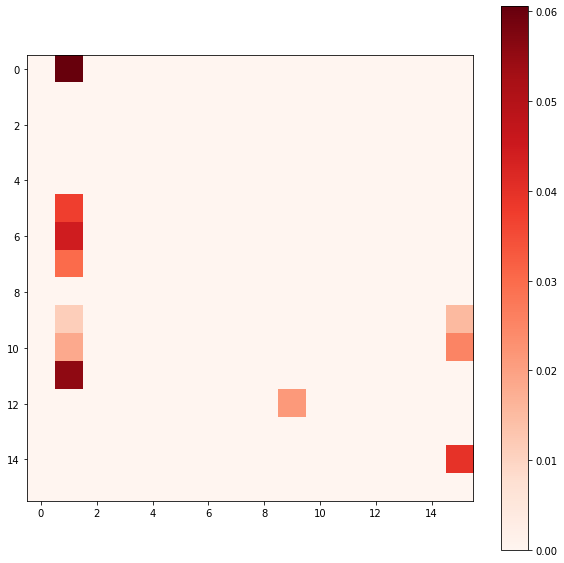

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(x_plot, cmap='Reds')
plt.colorbar()


### Find word in articles

In [ ]:
clean_articles = pd.read_csv('/content/drive/MyDrive/Colab Data/cluster_news/clean_articles.csv', sep=',')['content']
for i in range(len(clean_articles)):
    if clean_articles[i] is np.nan:
      clean_articles[i] = ' '

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_articles)


In [ ]:
terms = vectorizer.get_feature_names_out()

In [ ]:
terms

array(['ءات', 'ءاس', 'ءال', ..., 'يين', 'ييه', 'ييي'], dtype=object)

In [1]:
for i in range(len(clean_articles)):
  article = clean_articles[i]
  word = "علي"
  if re.search(word, article):
    print(i)


In [ ]:
clean_articles[30360]

'سخر جماهير ندي وير ريد ولز امر فرق وير سيت خلل برا ديرب جمع فرق اول امس ضمن نفس دور امر لكر قدم رفع درج ريد ولز لفت رسو عليها ثنء وير نجم خضرم يطل ندر رلو جلز برد وهم تكء علي عصا شره الي سنه كبر كتب علي لفت شفي سيت قاعد ونت برا بفز ريد ولز صفر ذكر ان وير سيت نضم خلل فتر نقل صيف حلي برد ندر رلو وجء عقد رلو عما قبل رتب سني قدر لاي عقد برد عما لمد عام صفق صفق كبر لنيويورك ديفيد فيا هجم سبق لبرشلونه اسب نضم الي فرق عام قبل'

In [ ]:
df_full['content'][30360]

' سخرت جماهير نادي نيويورك ريد بولز الأميركي من فريق نيويورك سيتى، خلال مباراة الديربى التى جمعت الفريقين أول من أمس، ضمن منافسات الدورى الأميركى لكرة القدم، ورفعت مدرجات ريد بولز لافتة مرسوما عليها ثنائي نيويورك النجمين المخضرمين، الإيطالي أندريا بيرلو، والإجليزي لامبارد، وهما مُتكئان على عصا، في إشارة إلى سنهما الكبير، ومكتوب على اللافتة مستشفى سيتي للمتقاعدين، وانتهت المباراة بفوز ريد بولز 2/صفر.\n يذكر أن نيويورك سيتي انضم له خلال فترة الانتقالات الصيفية الحالية لامبارد وأندريا بيرلو. وجاء التعاقد مع بيرلو "36 عاما" بمقابل راتب سنوي يقدر بـ10 ملايين يورو، فيما تعاقد مع لامبارد "37 عاما" لمدة عامين في ثاني صفقة صفقة كبرى لنيويورك بعد ديفيد فيا المهاجم السابق لبرشلونة الإسباني الذي سينضم إلى الفريق العام المقبل. '

### Compare TSNE and PCA

In [ ]:
svd = TruncatedSVD(n_components=2000)
X_svd = svd.fit_transform(X)

kmeans = KMeans(n_clusters=6)
kmeans.fit(X_svd)
labels = kmeans.labels_

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


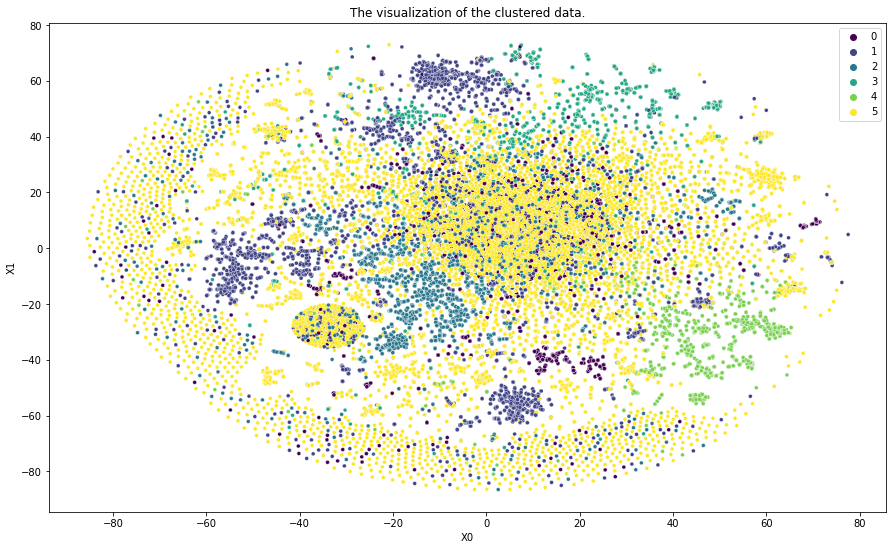

In [ ]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_svd)
tsne_df = pd.DataFrame(tsne_data, columns=['x1','x2'])

plot_clusters(tsne_df, labels)

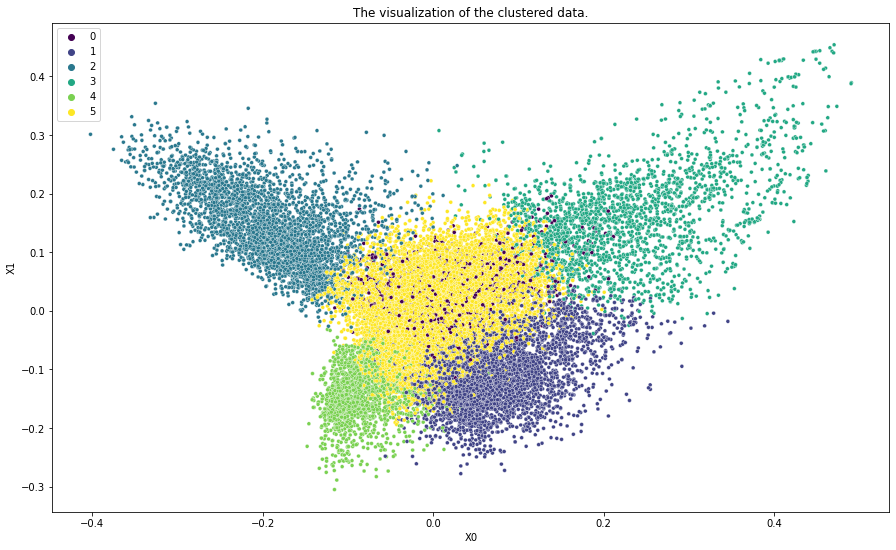

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_svd)
pca_df = pd.DataFrame(pca_data, columns=['x1','x2'])

plot_clusters(pca_df, labels)

### Dimension Reduction

In [ ]:
pca = TruncatedSVD(n_components=2000)
X_pca = pca.fit_transform(X)

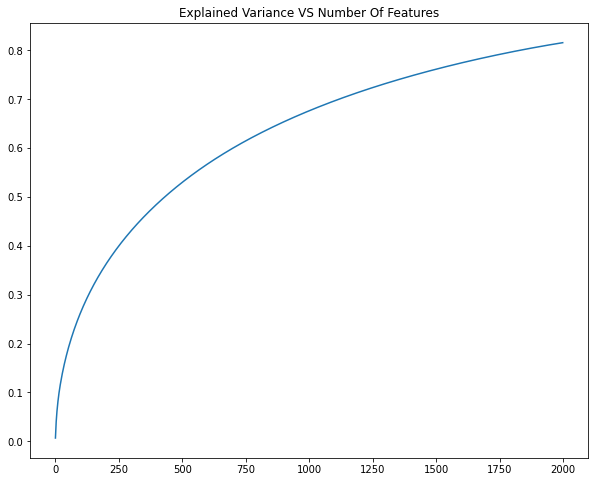

In [ ]:
plt.figure(figsize=(10,8))
plt.title("Explained Variance VS Number Of Features")
sns.lineplot(x=[i for i in range(2000)], y=np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
print("Total Explained Variance: ", np.cumsum(pca.explained_variance_ratio_)[-1])

Total Explained Variance:  0.8158207022016565


### Elbow plot to visually select the optimal clusters

SSD = Sum of squared distances

In [ ]:
SSD = []

for k in tqdm(range(2, 20)):
    km = KMeans(n_clusters=k)
    km = km.fit(X_pca200)
    SSD.append(km.inertia_)

100%|██████████| 18/18 [03:12<00:00, 10.68s/it]


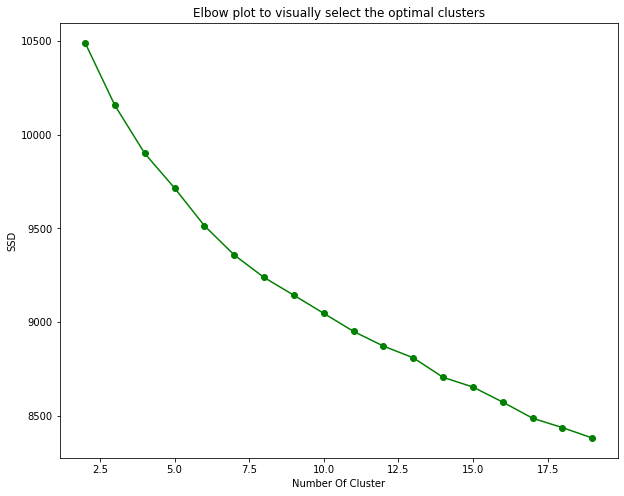

In [ ]:
plt.figure(figsize=(10,8))
plt.title("Elbow plot to visually select the optimal clusters")
plt.plot(range(2,20), SSD,'go-')
plt.xlabel("Number Of Cluster")
plt.ylabel("SSD")
plt.show()

In [ ]:
SSD = []

for k in tqdm(range(2, 30, 2)):
    km = KMeans(n_clusters=k)
    km = km.fit(X_pca)
    SSD.append(km.inertia_)

100%|██████████| 14/14 [16:44<00:00, 71.76s/it]


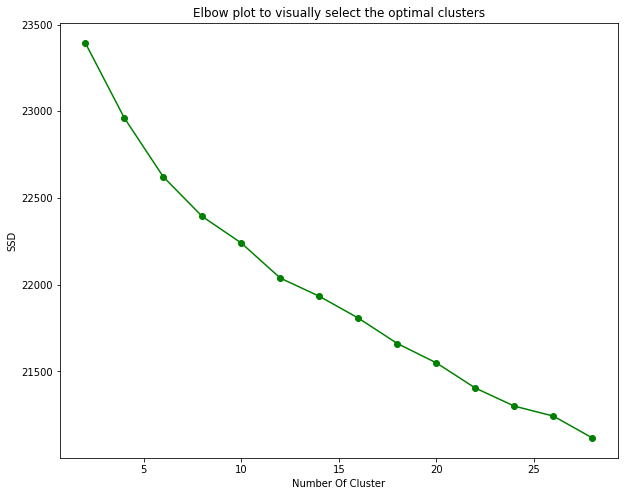

In [ ]:
plt.figure(figsize=(10,8))
plt.title("Elbow plot to visually select the optimal clusters")
plt.plot(range(2,30, 2), SSD,'go-')
plt.xlabel("Number Of Cluster")
plt.ylabel("SSD")
plt.show()

### Plot

In [ ]:
svd200 = TruncatedSVD(n_components=200)
X_svd200 = svd200.fit_transform(X)

kmeans200 = KMeans(n_clusters=6)
kmeans200.fit(X_svd200)
labels200 = kmeans200.labels_

In [ ]:
tsne200 = TSNE(n_components=2)
tsne_data200 = tsne200.fit_transform(X_svd200)
tsne_df200 = pd.DataFrame(tsne_data200, columns=['x1','x2'])

best_terms200 = [terms[i] for i in svd200.components_[0].argsort()[::-1]]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


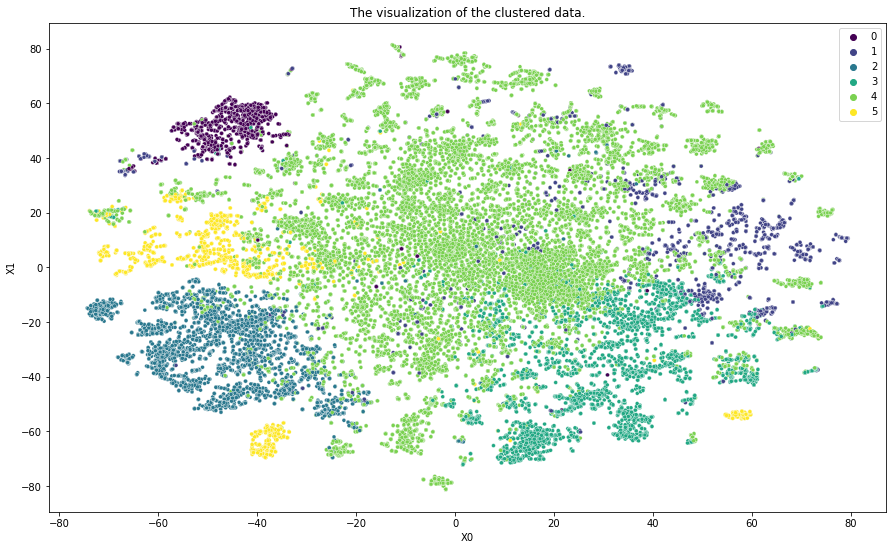

In [ ]:
plot_clusters(tsne_df200, labels200)


In [ ]:
svd2000 = TruncatedSVD(n_components=2000)
X_svd2000 = svd2000.fit_transform(X)

kmeans = KMeans(n_clusters=6)
kmeans.fit(X_svd2000)
labels = kmeans.labels_

In [ ]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_svd2000)
tsne_df = pd.DataFrame(tsne_data, columns=['x1','x2'])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
best_terms = [terms[i] for i in svd2000.components_[0].argsort()[::-1]]


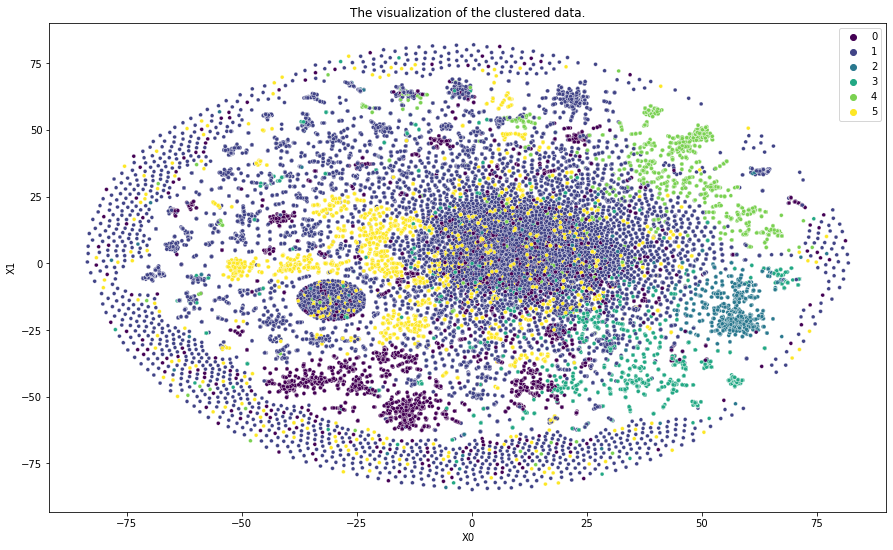

In [ ]:
plot_clusters(tsne_df, labels)

## Silhouette analysis for KMeans clustering

In [ ]:
X = download_clean_vec_data()

In [ ]:
def silhouette(X, pca_data, pca, min_cluster, max_cluster):
  for n_clusters in range(min_cluster, max_cluster):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 0.3])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer.fit(X)
    cluster_labels = clusterer.labels_
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
      ith_cluster_silhouette_values.sort()
      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i
      
      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(
          np.arange(y_lower, y_upper),
              0,
              ith_cluster_silhouette_values,
              facecolor=color,
              edgecolor=color,
              alpha=0.7,
          )
      
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      
      y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax2.scatter(pca_data[:,0], pca_data[:,1], marker=".", s=25, lw=0, c=colors)
    
    centers = pca.transform(clusterer.cluster_centers_)
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")

    plt.suptitle(
          "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
          % n_clusters,
          fontsize=14,
          fontweight="bold",
      )

  plt.show()

In [ ]:
svd = TruncatedSVD(n_components=2000)
X_svd = svd.fit_transform(X)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_svd)

For n_clusters = 2 The average silhouette_score is : 0.010240547074296807
For n_clusters = 3 The average silhouette_score is : 0.014957327320385657
For n_clusters = 4 The average silhouette_score is : 0.01613121579487471
For n_clusters = 5 The average silhouette_score is : 0.018723558032477286
For n_clusters = 6 The average silhouette_score is : 0.02043658995342343
For n_clusters = 7 The average silhouette_score is : 0.016138081159940823
For n_clusters = 8 The average silhouette_score is : 0.01791618105510465
For n_clusters = 9 The average silhouette_score is : 0.014752006091053892
For n_clusters = 10 The average silhouette_score is : 0.020815377093255677
For n_clusters = 11 The average silhouette_score is : 0.009229174050629424
For n_clusters = 12 The average silhouette_score is : 0.019967639929209302
For n_clusters = 13 The average silhouette_score is : 0.019606885724959087
For n_clusters = 14 The average silhouette_score is : 0.011459721058727383


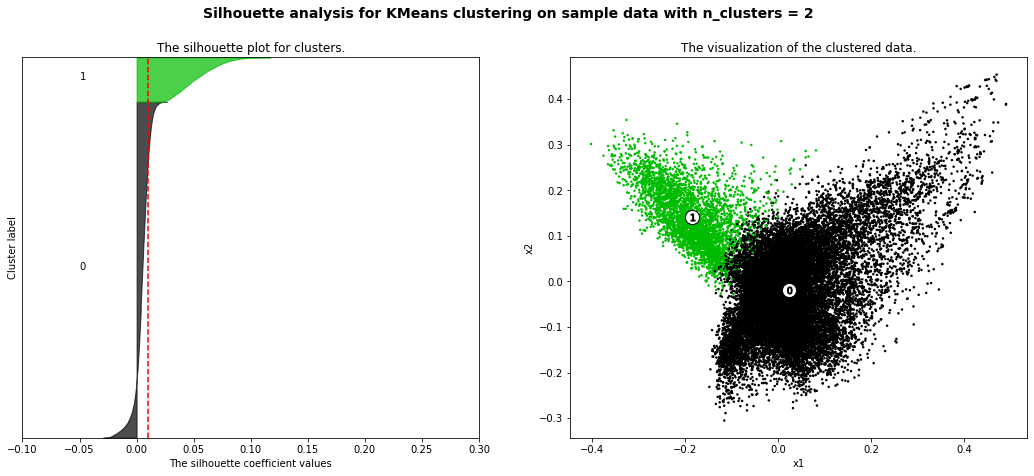

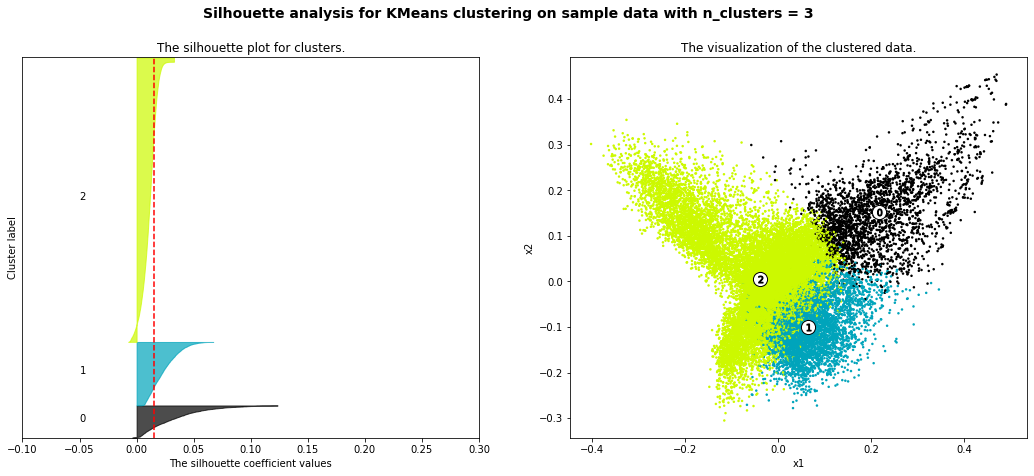

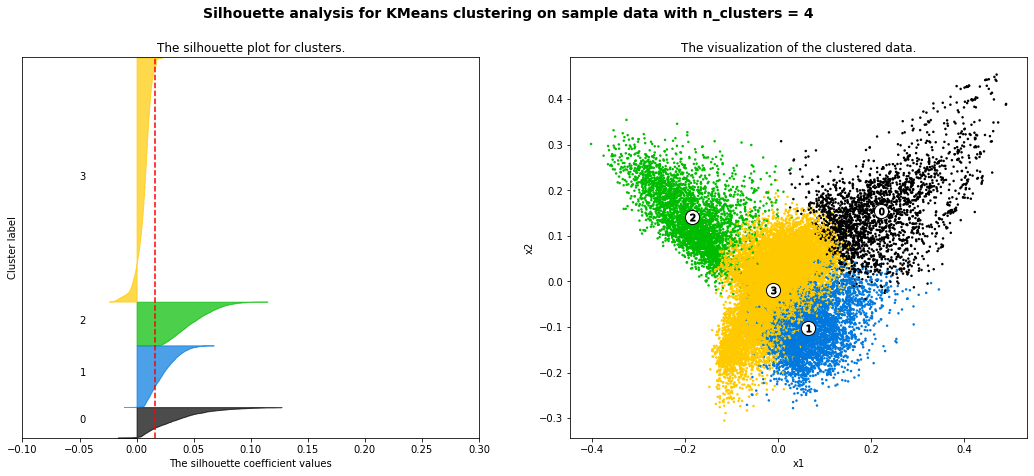

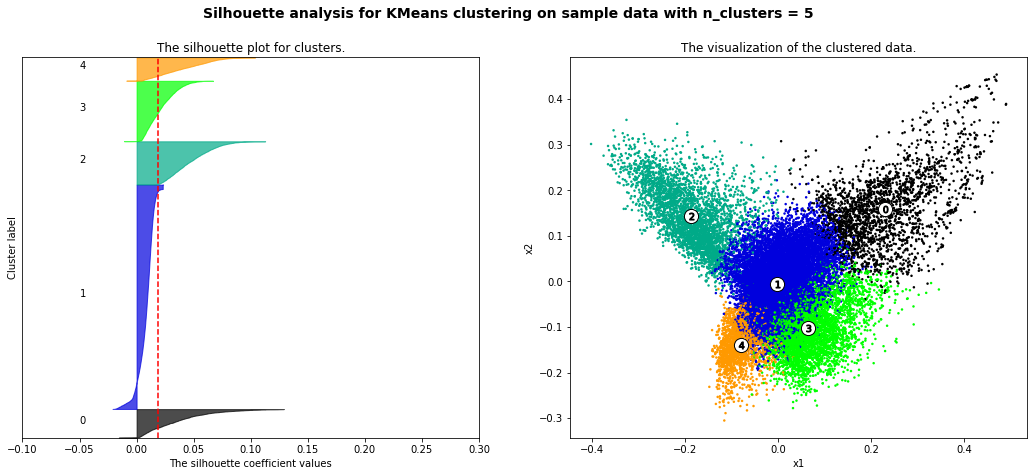

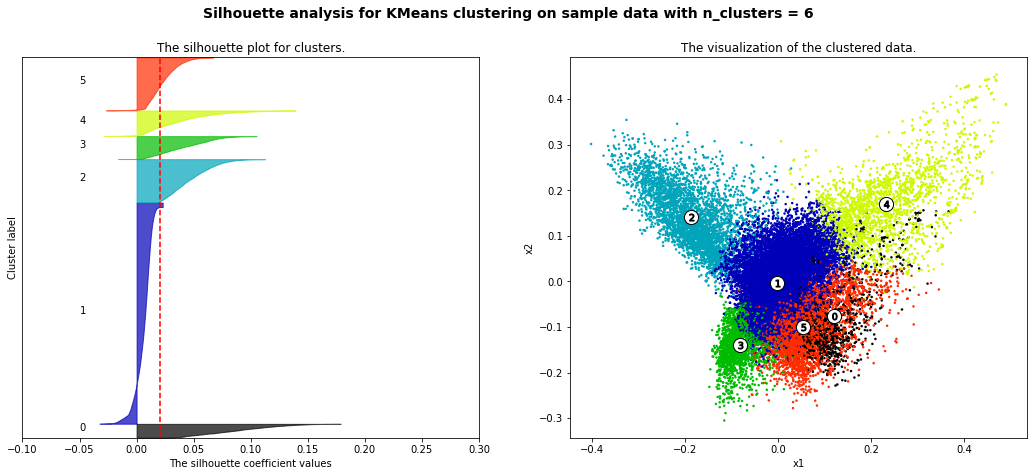

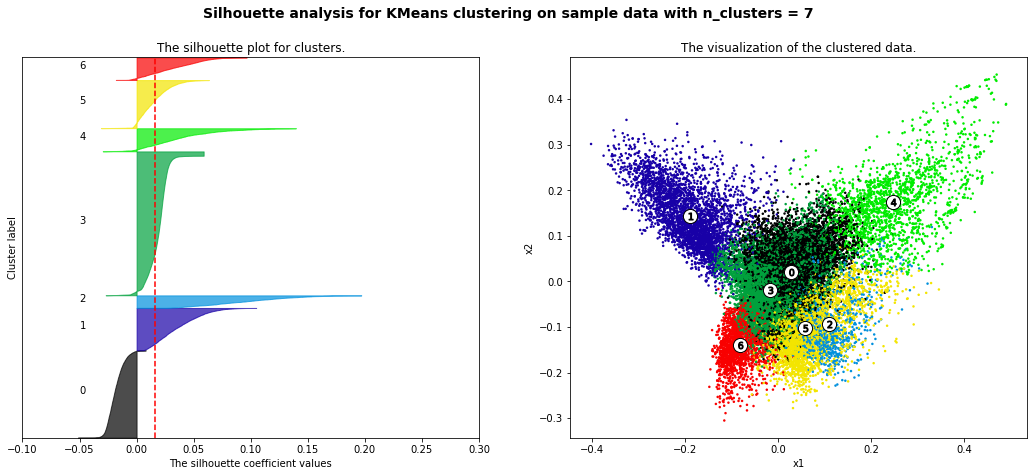

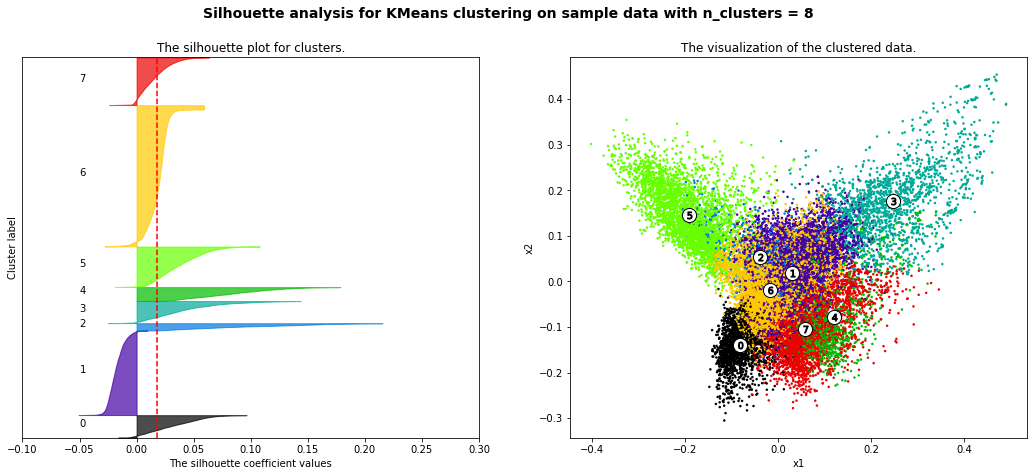

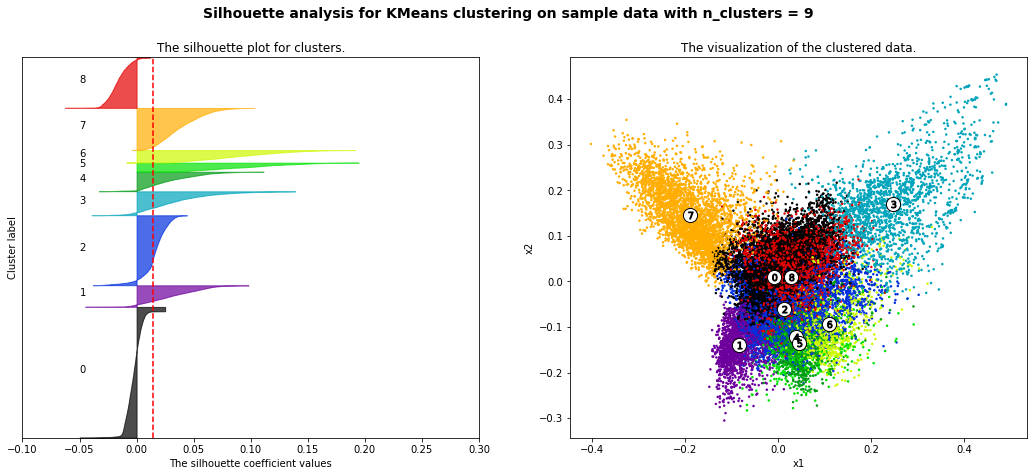

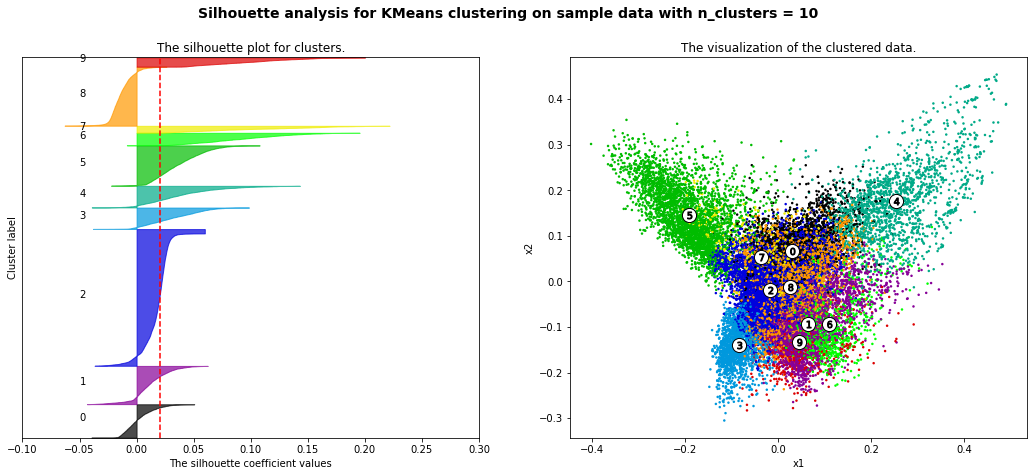

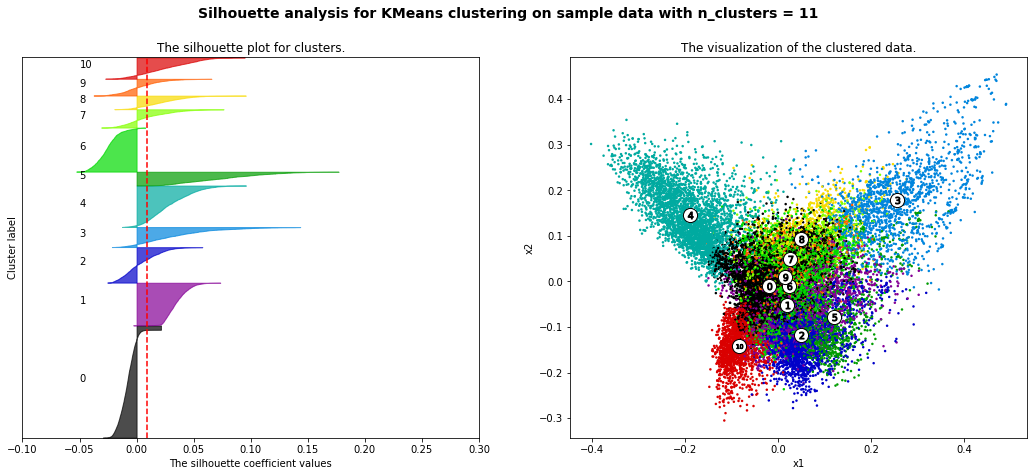

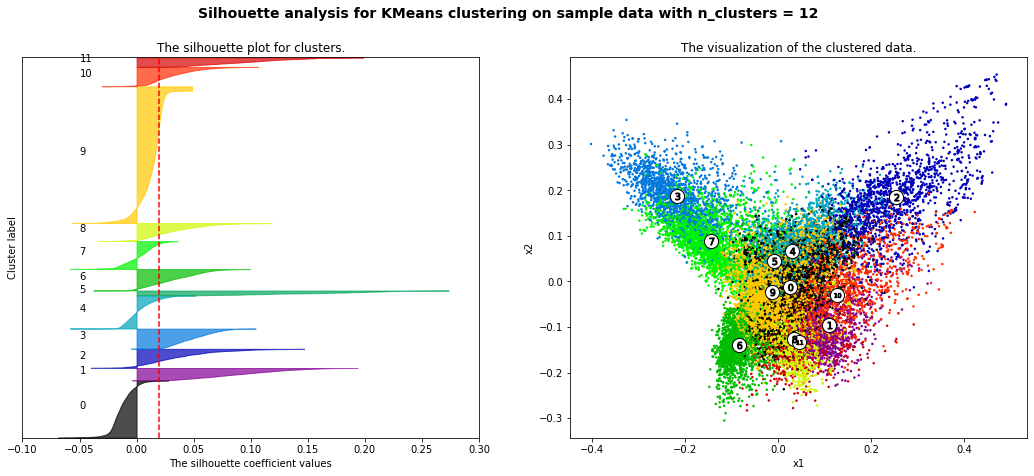

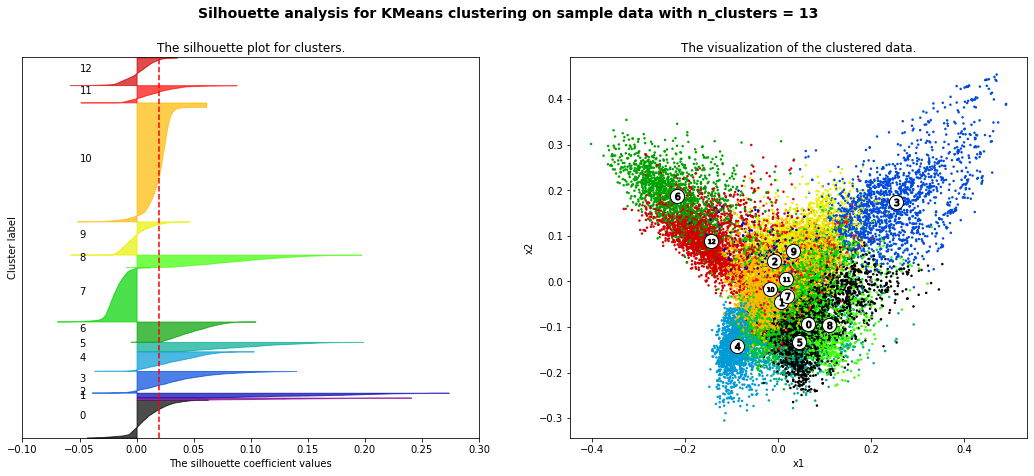

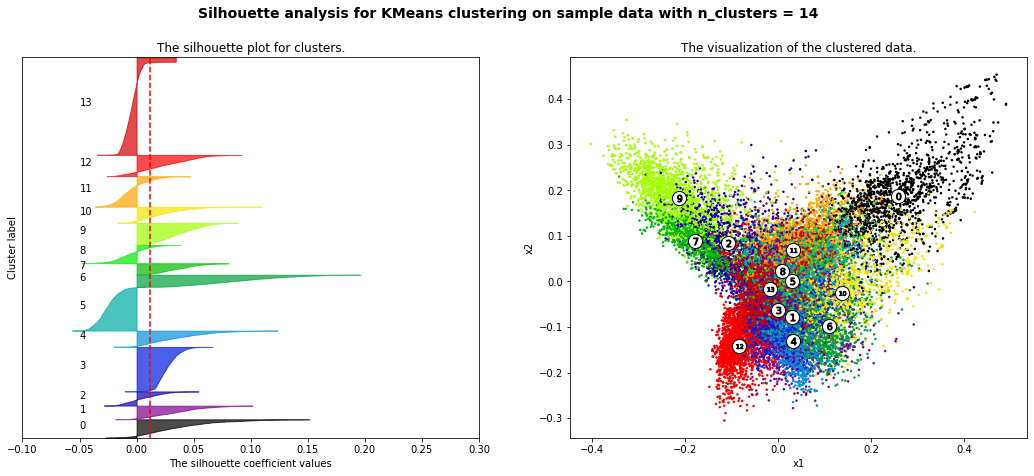

In [ ]:
silhouette(X_svd, pca_data, pca, 2, 15)

## Clustering Algorithms

In [ ]:
X, terms, vectorizer = download_clean_vec_data()

In [ ]:
X

<31030x32801 sparse matrix of type '<class 'numpy.float64'>'
	with 4187585 stored elements in Compressed Sparse Row format>

In [ ]:
svd = TruncatedSVD(n_components=500)
X_svd = svd.fit_transform(X)

best_terms = [terms[i] for i in svd.components_[0].argsort()[::-1]]

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_svd)

In [ ]:
def top_words(model, terms, num_words=20, n_clusters=6):
  order_centroids = model.cluster_centers_.argsort()[:, :-num_words:-1]

  for num, centroid in enumerate(order_centroids):
    print(f'Cluster {num}:')
    print(', '.join(terms[i] for i in centroid))

In [ ]:
def clustering(X, cluster_labels, pca_data, name='KMeans'):
  n_clusters = len(np.unique(cluster_labels))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 0.3])
  ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
  
  silhouette_avg = silhouette_score(X, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)
  
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

  ax1.set_title("The silhouette plot for clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

  ax2.scatter(pca_data[:,0], pca_data[:,1], marker=".", s=25, lw=0, c=colors)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("x1")
  ax2.set_ylabel("x2")

  plt.suptitle(
        f"Silhouette analysis for {name} clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

  plt.show()

### K-means clustering algorithm

For n_clusters = 6 The average silhouette_score is : 0.012034870195157652


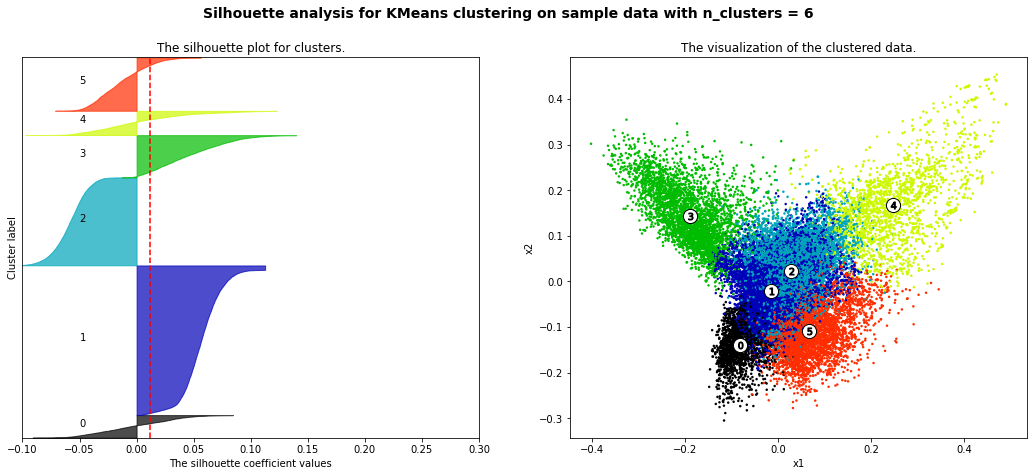

In [ ]:
kmeans_modelr = KMeans(n_clusters=6, init='random')
kmeans_modelr = kmeans_modelr.fit(X_svd)
kmeans_labelsr = kmeans_modelr.labels_

clustering(X_svd, kmeans_labelsr, pca_data)

### Kmeans++

For n_clusters = 6 The average silhouette_score is : 0.028607742783878252


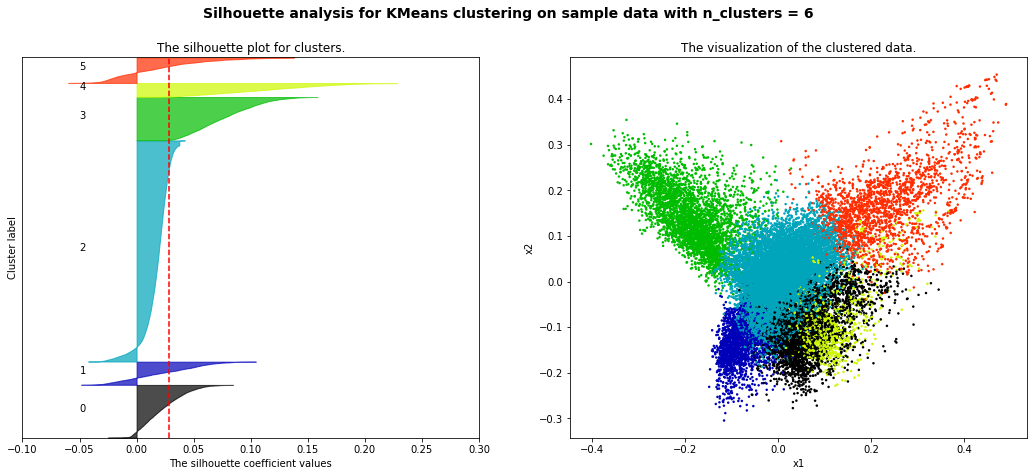

In [ ]:
kmeans_model = KMeans(n_clusters=6, init='k-means++')
kmeans_model = kmeans_model.fit(X_svd)
kmeans_labels = kmeans_model.labels_

clustering(X_svd, kmeans_labels, pca_data)

### DBSCAN clustering algorithm

In [ ]:
dbscan_model = DBSCAN(eps=0.1, min_samples=25)
dbscan_labels = dbscan_model.fit_predict(X_svd)


For n_clusters = 2 The average silhouette_score is : -0.24972013109318078


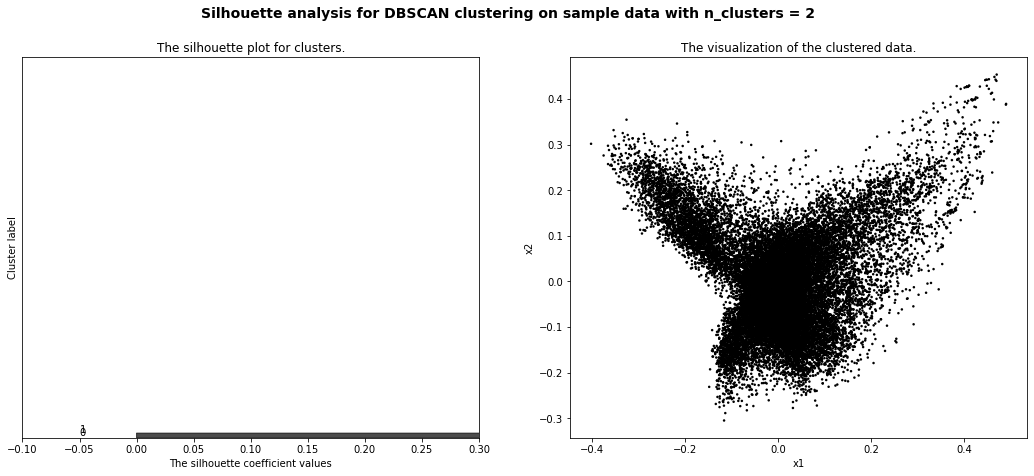

In [ ]:
clustering(X_svd, dbscan_labels, pca_data, name='DBSCAN')

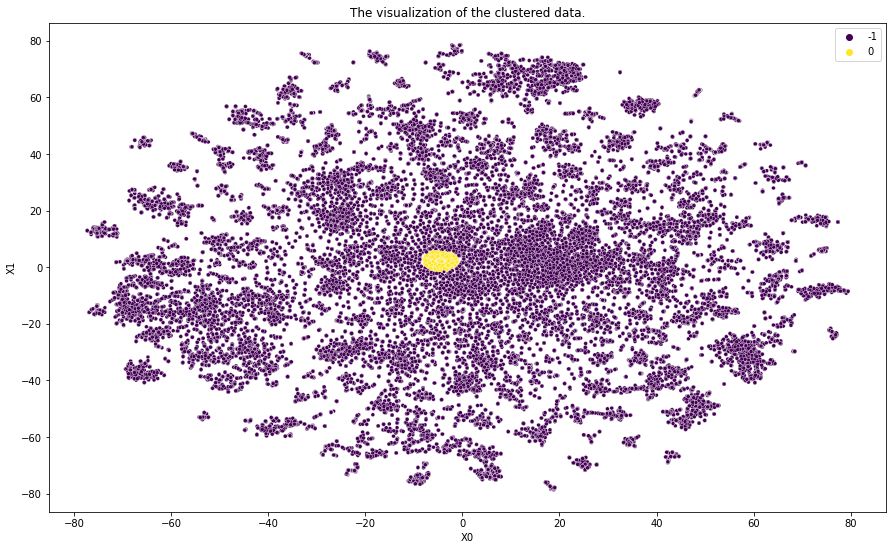

In [ ]:
plot_clusters(tsne_df, dbscan_labels)

### Gaussian Mixture Model algorithm

In [ ]:
gmm_model = GaussianMixture(n_components=6)
gmm_labels = gmm_model.fit_predict(X_svd)

For n_clusters = 6 The average silhouette_score is : 0.005638837244591315


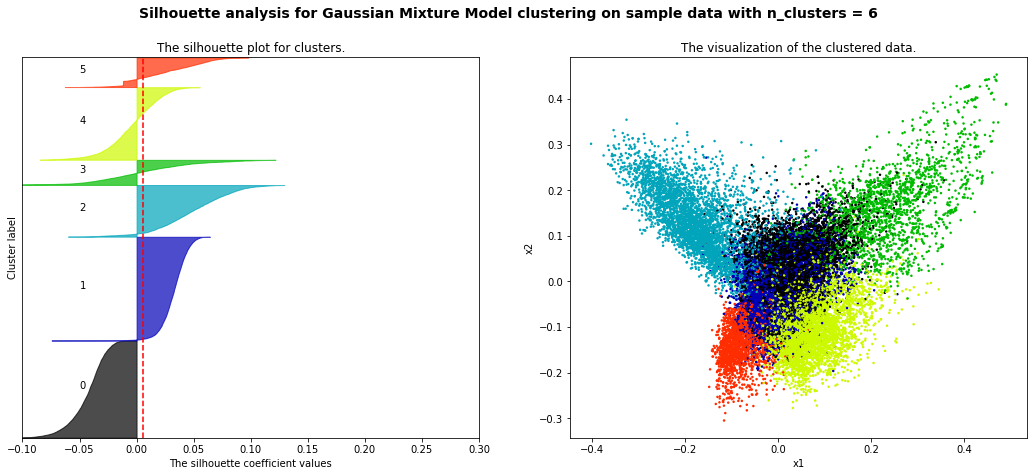

In [ ]:
clustering(X_svd, gmm_labels, pca_data, name='Gaussian Mixture Model')

### Agglomerative Hierarchy clustering algorithm

In [ ]:
agglomerative_model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')
agglomerative_labels = agglomerative_model.fit_predict(X_svd)


For n_clusters = 6 The average silhouette_score is : 0.005638837244591315


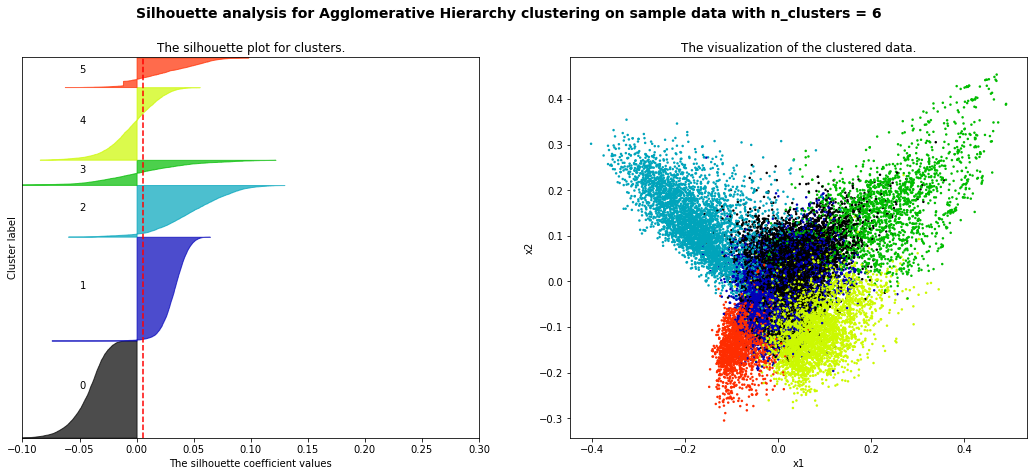

In [ ]:
clustering(X_svd, gmm_labels, pca_data, name='Agglomerative Hierarchy')

## Result

In [ ]:
top_words(kmeans_model, best_terms)

Cluster 0:
علي, عمل, بن, ان, دول, امر, فرق, دين, او, انه, جنب, تحد, جلس, طقه, عام, حقق, رهب, جدد, وطن
Cluster 1:
علي, جمع, بن, دول, سلم, فرق, وزر, امن, عبر, حدث, قبل, وطن, علم, وقع, يمن, طقه, دين, فعل, حمد
Cluster 2:
علي, علم, شرك, رءس, بلد, عام, وزر, خرج, دخل, اخر, شرع, حكم, سلم, امر, سعد, صدر, لعب, نسب, بين
Cluster 3:
علي, الي, عمل, جمع, طقه, خدم, الل, قدم, تحد, حمد, رهب, كتب, دين, وفي, كبر, قتل, خصه, حقق, حول
Cluster 4:
علي, علم, عمل, جمع, ان, سعد, سلم, قدم, امر, يمن, وزر, جدد, جلس, دول, عبر, شرف, ملك, تفق, شكل
Cluster 5:
علي, ان, الي, جمع, وزر, نظم, قدم, ملك, خدم, رءس, عرب, عدد, وطن, امن, دير, يمن, طرق, سلم, كثر


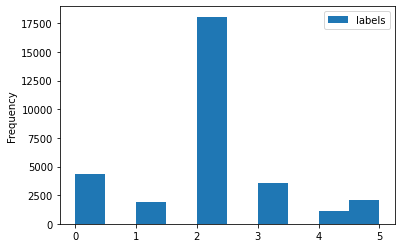

In [ ]:
cluster_title = pd.DataFrame({"title" : df_full['title'],
                              "labels" : kmeans_labels})

cluster_title.plot.hist()

In [ ]:
cluster_title[cluster_title['labels']==0]

title  labels
0      بريطانيا: أربعة محاور لاستراتيجية جديدة تتصدى ...       0
2      مجلس الأمن يصادق على «الاتفاق النووي».. وإيران...       0
3      «نيران صديقة» أميركية تودي بحياة 14 جنديا أفغانيا       0
6      أوباما يتحدى الكونغرس ويذهب بالاتفاق النووي إل...       0
7             حماس تتلقى «رسالة تحدٍ» بـ5 تفجيرات في غزة       0
...                                                  ...     ...
30952  عام / الجامعة العربية تنعي سعد الدوابشة الذي و...       0
30992  عام / مقتل ثلاثة لاجئين فلسطينيين بقصف قوات ال...       0
31000  عام / مصرع ثلاثة أشخاص بحوادث أمنية متفرقة في ...       0
31007  سياسي / معالي وزير الخارجية يلتقي نظيره الروسي...       0
31009     سياسي / معالي وزير الخارجية يلتقي نظيره الروسي       0

[4313 rows x 2 columns]

In [ ]:
indexes = np.random.randint(len(df_full), size=10)
articles = df_full.iloc[indexes]
x = articles.content.apply(lambda text: clean_text(text))

x_vec = vectorizer.transform(x)
x_svd = svd.transform(x_vec)

In [ ]:
pred = kmeans_model.predict(x_svd)
for i, p in enumerate(pred):
  print(articles.title.iloc[i])
  print('Cluster: ', p)
  print()

20 ألف حاج يمني يؤدون الحج.. وخمسة منافذ مقترحة لقدومهم
Cluster:  4

وصول طائرات إغاثية سعودية وإماراتية إلى عدن
Cluster:  4

3 شرائح لمسار حجاج الداخل
Cluster:  2

مدير جامعة طيبة: على جميع أبناء الوطن مسؤولية كبيرة لضمان سلامته وحفظ أمنه 
Cluster:  2

أميركا.. المبتعث المتهم في قضية قدر الضغط يدفع ببراءته
Cluster:  2

تحركات اتحادية لحسم صفقة «اللاعب الآسيوي»
Cluster:  3

الذهب يرتفع لأعلى مستوى في 3 أسابيع مع دراسة مستثمرين خطوة الصين
Cluster:  1

وزير التعليم يدعو مسؤولي "تواصل" للتفاعل مع المستفيدين 
Cluster:  2

أقارب ضحايا الطائرة المفقودة MH370 يطالبون بدعم أكبر من ماليزيا ايرلاينز
Cluster:  2

القروض الاستهلاكية ..  ظاهرة يجب تفحصها بدقة
Cluster:  1

